# App-6 - Demineur : CSP, Probabilites et NP-completude

**Navigation** : [<< App-5 Timetabling](App-5-Timetabling.ipynb) | [Index](../README.md) | [App-7 Wordle >>](App-7-Wordle.ipynb)

## Objectifs d'apprentissage

A la fin de ce notebook, vous saurez :
1. **Modeliser** le Demineur comme un probleme de satisfaction de contraintes (CSP)
2. **Implementer** un solveur par regles simples pour les cas non ambigus
3. **Construire** un solveur CSP qui enumere les solutions et deduit les cellules sures/minees
4. **Etendre** le solveur avec un raisonnement probabiliste pour les cas ambigus
5. **Comparer** les trois approches en termes de taux de victoire et de performance

### Prerequis
- Python 3.10+, numpy, matplotlib
- `python-constraint` (CSP)
- Notions de CSP (Search-6 et Search-7)

### Duree estimee : 50 minutes

### Source

Adapte du projet etudiant EPITA PPC 2025 : [jsboigeEpita/2025-PPC RDER-minesweeper](https://github.com/jsboigeEpita/2025-PPC) (CSP + probabilites, preuve NP-completude).

---

## 1. Introduction : le Demineur comme probleme de contraintes (~5 min)

Le **Demineur** (Minesweeper) est un jeu classique ou le joueur doit reveler toutes les cellules sures d'une grille sans cliquer sur une mine. Chaque cellule revelee affiche un nombre indiquant combien de ses 8 voisines contiennent une mine.

### Pourquoi le Demineur interesse-t-il l'IA ?

Le Demineur est bien plus qu'un jeu : c'est un **probleme NP-complet**. Richard Kaye a demontre en 2000 que determiner si une configuration de Demineur est consistante (c'est-a-dire s'il existe un placement de mines compatible avec les indices visibles) est **NP-complet**.

| Propriete | Valeur |
|-----------|--------|
| Complexite | NP-complet (Kaye, 2000) |
| Type de probleme | Satisfaction de contraintes |
| Variables | Cellules inconnues (mine ou sure) |
| Contraintes | Indices numeriques des cellules revelees |
| Reduction | Reduction depuis SAT / Circuit-SAT |

### Modelisation CSP

Le Demineur se modelise naturellement comme un CSP :

- **Variables** : chaque cellule non revelee $C_{i,j}$ est une variable binaire
- **Domaines** : $D_{i,j} = \{0, 1\}$ ou $0$ = sure, $1$ = mine
- **Contraintes** : pour chaque cellule revelee affichant la valeur $n$, la somme des variables voisines doit valoir exactement $n$ :

$$\sum_{(r,c) \in \text{voisins}(i,j)} C_{r,c} = n_{i,j}$$

- **Contrainte globale** : le nombre total de mines est connu

### Plan du notebook

Nous allons construire trois solveurs de complexite croissante :

| Approche | Principe | Quand l'utiliser |
|----------|----------|------------------|
| Regles simples | Deductions deterministes locales | Cas triviaux |
| CSP complet | Enumeration des solutions, cellules forcees | Cas ambigus localement |
| CSP + Probabilites | Comptage de solutions, choix optimal | Quand aucune cellule n'est forcee |

In [1]:
# Imports pour tout le notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from collections import defaultdict
from itertools import product
import random
import time
import sys
import copy

# CSP solver
from constraint import Problem, ExactSumConstraint

# Helpers partages de la serie Search
sys.path.insert(0, '..')
from search_helpers import benchmark_table

# Reproductibilite
random.seed(42)
np.random.seed(42)

print("Imports OK")

Imports OK


---

## 2. Representation du plateau (~5 min)

Avant de resoudre le Demineur, nous devons le representer. Le plateau est une grille 2D ou chaque cellule est dans l'un des etats suivants :

| Etat interne | Etat visible par le joueur | Description |
|--------------|----------------------------|-------------|
| Mine | Cache / Drapeau | Cellule contenant une mine |
| Sure (indice 0-8) | Cache / Revelee | Cellule sure avec nombre de mines voisines |

Nous implementons une classe `MinesweeperBoard` qui gere la generation du plateau et la revelation des cellules.

In [2]:
class MinesweeperBoard:
    """Plateau de Demineur avec generation, revelation et visualisation.

    Attributs:
        rows, cols: dimensions de la grille
        n_mines: nombre total de mines
        mines: ensemble de positions (r, c) contenant une mine
        numbers: grille des indices (nombre de mines voisines)
        revealed: ensemble de cellules revelees
        flagged: ensemble de cellules marquees comme mines
        game_over: True si une mine a ete revelee
        won: True si toutes les cellules sures sont revelees
    """

    NEIGHBORS_OFFSETS = [(-1, -1), (-1, 0), (-1, 1),
                         (0, -1),           (0, 1),
                         (1, -1),  (1, 0),  (1, 1)]

    def __init__(self, rows=8, cols=8, n_mines=10, safe_cell=None):
        """Genere un plateau aleatoire.

        Args:
            rows, cols: dimensions
            n_mines: nombre de mines
            safe_cell: position (r, c) garantie sans mine (premier clic)
        """
        self.rows = rows
        self.cols = cols
        self.n_mines = n_mines
        self.revealed = set()
        self.flagged = set()
        self.game_over = False
        self.won = False

        # Generer les mines en evitant safe_cell et ses voisins
        all_cells = [(r, c) for r in range(rows) for c in range(cols)]
        excluded = set()
        if safe_cell is not None:
            excluded.add(safe_cell)
            excluded.update(self.get_neighbors(*safe_cell))

        candidates = [cell for cell in all_cells if cell not in excluded]
        self.mines = set(random.sample(candidates, min(n_mines, len(candidates))))

        # Calculer les indices (nombre de mines voisines pour chaque cellule)
        self.numbers = np.zeros((rows, cols), dtype=int)
        for r in range(rows):
            for c in range(cols):
                if (r, c) not in self.mines:
                    self.numbers[r, c] = sum(
                        1 for nr, nc in self.get_neighbors(r, c)
                        if (nr, nc) in self.mines
                    )

    def get_neighbors(self, r, c):
        """Retourne les positions voisines valides de (r, c)."""
        neighbors = []
        for dr, dc in self.NEIGHBORS_OFFSETS:
            nr, nc = r + dr, c + dc
            if 0 <= nr < self.rows and 0 <= nc < self.cols:
                neighbors.append((nr, nc))
        return neighbors

    def reveal(self, r, c):
        """Revele la cellule (r, c). Retourne True si sure, False si mine."""
        if (r, c) in self.revealed or (r, c) in self.flagged:
            return True

        if (r, c) in self.mines:
            self.game_over = True
            return False

        self.revealed.add((r, c))

        # Si la cellule est un 0, reveler en cascade les voisins
        if self.numbers[r, c] == 0:
            for nr, nc in self.get_neighbors(r, c):
                if (nr, nc) not in self.revealed:
                    self.reveal(nr, nc)

        # Verifier la victoire
        safe_cells = self.rows * self.cols - len(self.mines)
        if len(self.revealed) == safe_cells:
            self.won = True

        return True

    def flag(self, r, c):
        """Marque/demarque une cellule comme mine."""
        if (r, c) not in self.revealed:
            if (r, c) in self.flagged:
                self.flagged.discard((r, c))
            else:
                self.flagged.add((r, c))

    def get_unknown_neighbors(self, r, c):
        """Retourne les voisins ni reveles ni marques."""
        return [
            (nr, nc) for nr, nc in self.get_neighbors(r, c)
            if (nr, nc) not in self.revealed and (nr, nc) not in self.flagged
        ]

    def get_flagged_neighbors(self, r, c):
        """Retourne les voisins marques comme mines."""
        return [
            (nr, nc) for nr, nc in self.get_neighbors(r, c)
            if (nr, nc) in self.flagged
        ]

    def remaining_mines(self):
        """Nombre de mines non encore marquees."""
        return self.n_mines - len(self.flagged)

    def copy(self):
        """Retourne une copie profonde du plateau."""
        board = MinesweeperBoard.__new__(MinesweeperBoard)
        board.rows = self.rows
        board.cols = self.cols
        board.n_mines = self.n_mines
        board.mines = set(self.mines)
        board.numbers = self.numbers.copy()
        board.revealed = set(self.revealed)
        board.flagged = set(self.flagged)
        board.game_over = self.game_over
        board.won = self.won
        return board

print("Classe MinesweeperBoard definie.")

Classe MinesweeperBoard definie.


### Visualisation du plateau

La fonction suivante dessine le plateau avec un code couleur clair :
- Gris : cellule cachee
- Blanc avec chiffre : cellule revelee
- Rouge avec drapeau : cellule marquee comme mine
- Noir (game over) : mine revelee

In [3]:
# Couleurs pour les chiffres du demineur (convention classique)
NUMBER_COLORS = {
    0: '#CCCCCC', 1: '#0000FF', 2: '#008000', 3: '#FF0000',
    4: '#000080', 5: '#800000', 6: '#008080', 7: '#000000', 8: '#808080'
}


def draw_board(board, title="Demineur", show_mines=False,
               highlight_safe=None, highlight_mines=None,
               probabilities=None, figsize=None):
    """Visualise le plateau de Demineur.

    Args:
        board: MinesweeperBoard
        title: titre du graphique
        show_mines: reveler toutes les mines (fin de partie)
        highlight_safe: ensemble de cellules a surligner en vert (deduites sures)
        highlight_mines: ensemble de cellules a surligner en rouge (deduites mines)
        probabilities: dict (r,c) -> probabilite de mine (pour affichage)
    """
    if figsize is None:
        figsize = (max(6, board.cols * 0.7), max(6, board.rows * 0.7))

    fig, ax = plt.subplots(figsize=figsize)

    for r in range(board.rows):
        for c in range(board.cols):
            # Determiner la couleur de fond
            if (r, c) in board.revealed:
                bg_color = '#E8E8E8'  # Gris clair pour revelee
            elif (r, c) in board.flagged:
                bg_color = '#FFB3B3'  # Rouge clair pour drapeau
            elif highlight_safe and (r, c) in highlight_safe:
                bg_color = '#B3FFB3'  # Vert clair pour sure deduites
            elif highlight_mines and (r, c) in highlight_mines:
                bg_color = '#FF6666'  # Rouge pour mine deduite
            else:
                bg_color = '#C0C0C0'  # Gris pour cachee

            rect = plt.Rectangle((c, board.rows - 1 - r), 1, 1,
                                 facecolor=bg_color, edgecolor='#666666',
                                 linewidth=1)
            ax.add_patch(rect)

            # Contenu de la cellule
            cx, cy = c + 0.5, board.rows - 1 - r + 0.5

            if (r, c) in board.revealed:
                num = board.numbers[r, c]
                if num > 0:
                    ax.text(cx, cy, str(num), ha='center', va='center',
                            fontsize=14, fontweight='bold',
                            color=NUMBER_COLORS.get(num, 'black'))
            elif (r, c) in board.flagged:
                ax.text(cx, cy, 'F', ha='center', va='center',
                        fontsize=12, fontweight='bold', color='darkred')
            elif show_mines and (r, c) in board.mines:
                ax.text(cx, cy, 'X', ha='center', va='center',
                        fontsize=14, fontweight='bold', color='black')
            elif probabilities and (r, c) in probabilities:
                prob = probabilities[(r, c)]
                ax.text(cx, cy, f'{prob:.0%}', ha='center', va='center',
                        fontsize=8, color='#444444')

    ax.set_xlim(0, board.cols)
    ax.set_ylim(0, board.rows)
    ax.set_aspect('equal')
    ax.set_xticks(range(board.cols))
    ax.set_yticks(range(board.rows))
    ax.set_xticklabels(range(board.cols))
    ax.set_yticklabels(range(board.rows - 1, -1, -1))
    ax.set_xlabel('Colonne')
    ax.set_ylabel('Ligne')
    ax.set_title(title, fontsize=13, fontweight='bold')
    plt.tight_layout()
    return fig


print("Fonction draw_board definie.")

Fonction draw_board definie.


Creons un plateau 8x8 avec 10 mines et simulons un premier clic pour reveler quelques cellules.

Plateau : 8x8, 10 mines
Cellules revelees apres le premier clic : 44
Cellules restantes (inconnues)           : 20
Mines a trouver                          : 10


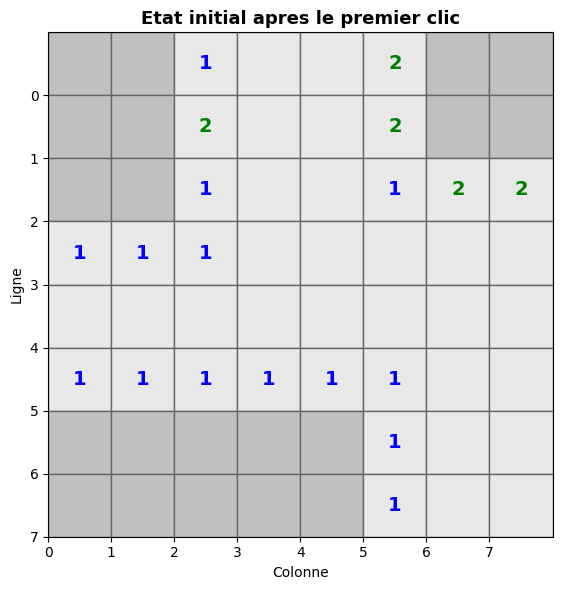

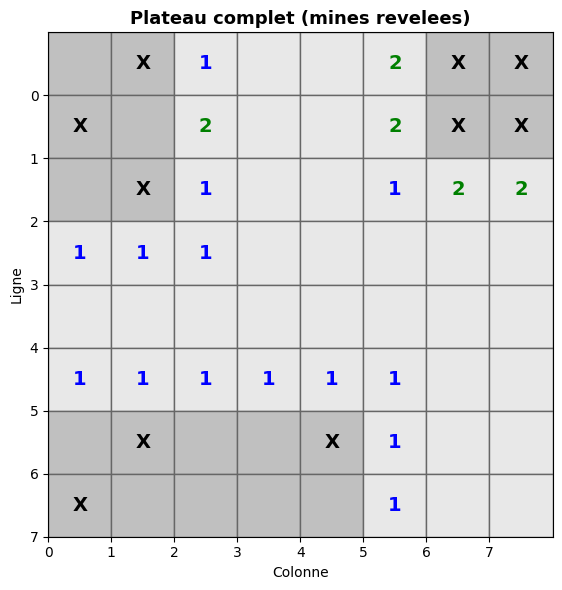

In [4]:
# Creer un plateau avec premier clic garanti sur
board = MinesweeperBoard(rows=8, cols=8, n_mines=10, safe_cell=(4, 4))
board.reveal(4, 4)  # Premier clic

print(f"Plateau : {board.rows}x{board.cols}, {board.n_mines} mines")
print(f"Cellules revelees apres le premier clic : {len(board.revealed)}")
print(f"Cellules restantes (inconnues)           : {board.rows * board.cols - len(board.revealed)}")
print(f"Mines a trouver                          : {board.remaining_mines()}")

# Visualiser l'etat initial
fig = draw_board(board, title="Etat initial apres le premier clic")
plt.show()

# Visualiser avec les mines (pour reference)
fig = draw_board(board, title="Plateau complet (mines revelees)", show_mines=True)
plt.show()

### Interpretation : representation du plateau

**Sortie obtenue** : deux vues du meme plateau -- la vue du joueur (cellules cachees en gris) et la vue complete avec les mines.

| Element | Signification |
|---------|---------------|
| Chiffre colore | Nombre de mines dans les 8 voisines |
| Gris uni | Cellule non revelee (inconnue) |
| X (vue complete) | Position d'une mine |

**Points cles** :
1. Le premier clic avec `safe_cell` garantit que ni la cellule cliquee ni ses voisines ne contiennent de mine -- c'est le comportement standard du jeu
2. Les cellules affichant 0 declenchent une revelation en cascade de leurs voisines
3. La frontiere entre cellules revelees et cachees constitue notre zone de travail pour le solveur

---

## 3. Approche 1 : solveur par regles simples (~8 min)

Le solveur le plus basique applique deux regles deterministes en boucle :

### Regle 1 -- Toutes les voisines sont des mines

Si une cellule revelee affiche $n$ et a exactement $n$ voisines inconnues (ni revelees ni marquees), alors **toutes** ces voisines sont des mines.

$$\text{unknown\_count}(i,j) = n_{i,j} - \text{flagged\_count}(i,j) \implies \text{marquer toutes les inconnues}$$

### Regle 2 -- Toutes les voisines sont sures

Si une cellule revelee affiche $n$ et a deja $n$ voisines marquees, alors toutes les voisines inconnues restantes sont **sures**.

$$\text{flagged\_count}(i,j) = n_{i,j} \implies \text{reveler toutes les inconnues}$$

Ces deux regles suffisent pour les configurations simples, mais echouent sur les cas ambigus.

In [5]:
class RuleBasedSolver:
    """Solveur par regles simples (deductions locales).

    Applique iterativement les regles 1 et 2 jusqu'a
    ce qu'aucune nouvelle deduction ne soit possible.
    """

    def __init__(self, board):
        self.board = board
        self.moves_log = []  # historique des coups

    def solve_step(self):
        """Applique un tour de regles. Retourne True si des progres ont ete faits."""
        progress = False

        for r in range(self.board.rows):
            for c in range(self.board.cols):
                if (r, c) not in self.board.revealed:
                    continue

                num = self.board.numbers[r, c]
                if num == 0:
                    continue

                unknown = self.board.get_unknown_neighbors(r, c)
                flagged = self.board.get_flagged_neighbors(r, c)
                remaining_mines = num - len(flagged)

                # Regle 1 : toutes les inconnues sont des mines
                if remaining_mines == len(unknown) and len(unknown) > 0:
                    for ur, uc in unknown:
                        self.board.flag(ur, uc)
                        self.moves_log.append(('flag', (ur, uc), (r, c)))
                        progress = True

                # Regle 2 : toutes les inconnues sont sures
                elif remaining_mines == 0 and len(unknown) > 0:
                    for ur, uc in unknown:
                        safe = self.board.reveal(ur, uc)
                        self.moves_log.append(('reveal', (ur, uc), (r, c)))
                        if not safe:
                            return False  # Mine touchee (ne devrait pas arriver)
                        progress = True

        return progress

    def solve(self, max_iterations=100):
        """Applique les regles jusqu'a convergence.

        Retourne le nombre d'iterations effectuees.
        """
        for i in range(max_iterations):
            if self.board.game_over or self.board.won:
                break
            if not self.solve_step():
                break
        return i + 1


print("Classe RuleBasedSolver definie.")

Classe RuleBasedSolver definie.


Testons le solveur par regles sur notre plateau d'exemple.

Solveur par regles simples
Iterations         : 5
Cellules revelees  : 44 -> 54 (+10)
Drapeaux poses     : 0 -> 9 (+9)
Cellules inconnues : 1
Partie gagnee      : True
Coups effectues    : 19


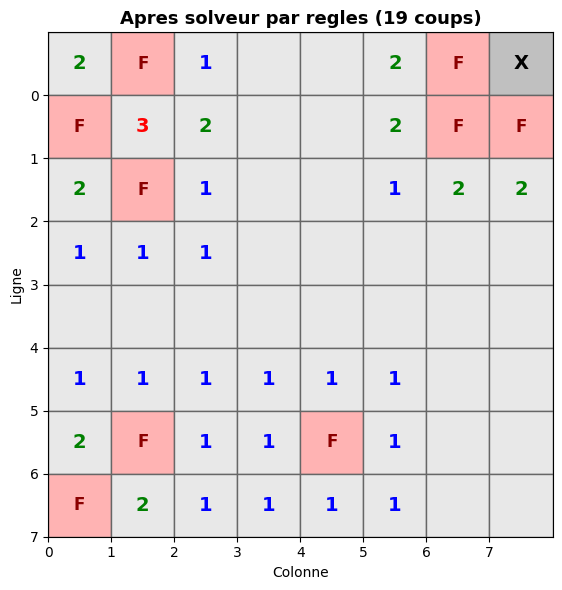

In [6]:
# Copier le plateau pour tester le solveur par regles
board_rules = board.copy()
solver_rules = RuleBasedSolver(board_rules)

# Etat avant
revealed_before = len(board_rules.revealed)
flagged_before = len(board_rules.flagged)

# Resoudre
iterations = solver_rules.solve()

# Resultats
revealed_after = len(board_rules.revealed)
flagged_after = len(board_rules.flagged)
total_cells = board_rules.rows * board_rules.cols
unknown_remaining = total_cells - revealed_after - flagged_after

print("Solveur par regles simples")
print("=" * 45)
print(f"Iterations         : {iterations}")
print(f"Cellules revelees  : {revealed_before} -> {revealed_after} (+{revealed_after - revealed_before})")
print(f"Drapeaux poses     : {flagged_before} -> {flagged_after} (+{flagged_after - flagged_before})")
print(f"Cellules inconnues : {unknown_remaining}")
print(f"Partie gagnee      : {board_rules.won}")
print(f"Coups effectues    : {len(solver_rules.moves_log)}")

# Visualiser le resultat
fig = draw_board(board_rules,
                 title=f"Apres solveur par regles ({len(solver_rules.moves_log)} coups)",
                 show_mines=True)
plt.show()

### Interpretation : solveur par regles

**Sortie obtenue** : le solveur par regles a effectue des deductions locales en quelques iterations.

| Mesure | Valeur | Commentaire |
|--------|--------|-------------|
| Iterations | Typiquement 3-8 | Convergence rapide |
| Cellules resolues | Variable | Depend de la configuration |
| Cellules restantes | >0 en general | Les cas ambigus ne sont pas resolus |

**Points cles** :
1. Les regles simples sont **rapides** (temps constant par cellule par iteration) et **sures** (pas de risque d'erreur)
2. Elles se bloquent quand aucune cellule n'est localement determinee -- c'est la **frontiere du raisonnement local**
3. En pratique, elles resolvent environ 30 a 50% des decisions sur un plateau 8x8 typique

> **Limite fondamentale** : les regles ne combinent pas les contraintes de plusieurs cellules revelees. Le CSP va combler cette lacune.

---

## 4. Approche 2 : solveur CSP (~12 min)

Le solveur CSP va plus loin que les regles simples en considerant **simultanement** toutes les contraintes. L'idee est :

1. **Modeliser** les cellules inconnues proches de la frontiere comme des variables binaires
2. **Poser les contraintes** : chaque cellule revelee impose une somme sur ses voisines inconnues
3. **Enumerer les solutions** du CSP
4. **Deduire** : si une variable vaut la meme chose (0 ou 1) dans **toutes** les solutions, elle est determinee

### Pourquoi est-ce plus puissant ?

Considerons cette configuration :

```
1  ?  ?
1  ?  ?
1  ?  ?
```

Les regles simples ne deduisent rien (chaque `1` a 2 ou 3 voisines inconnues). Mais en combinant les trois contraintes, le CSP peut determiner que certaines cellules sont necessairement sures ou minees.

### Optimisation : travailler sur la frontiere

Pour eviter d'enumerer les solutions sur toute la grille, nous ne considerons que les cellules inconnues **adjacentes a au moins une cellule revelee**. Les cellules completement isolees ne sont pas contraintes localement.

In [7]:
class CSPSolver:
    """Solveur CSP pour le Demineur.

    Utilise python-constraint pour enumerer les solutions
    et deduire les cellules determinee.
    """

    def __init__(self, board):
        self.board = board

    def get_frontier_cells(self):
        """Retourne les cellules inconnues adjacentes a une cellule revelee."""
        frontier = set()
        for r in range(self.board.rows):
            for c in range(self.board.cols):
                if (r, c) in self.board.revealed:
                    for nr, nc in self.board.get_neighbors(r, c):
                        if ((nr, nc) not in self.board.revealed and
                            (nr, nc) not in self.board.flagged):
                            frontier.add((nr, nc))
        return frontier

    def get_constraint_cells(self):
        """Retourne les cellules revelees qui contraignent des cellules inconnues."""
        constraint_cells = []
        for r in range(self.board.rows):
            for c in range(self.board.cols):
                if (r, c) not in self.board.revealed:
                    continue
                if self.board.numbers[r, c] == 0:
                    continue
                unknown = self.board.get_unknown_neighbors(r, c)
                if len(unknown) > 0:
                    flagged_count = len(self.board.get_flagged_neighbors(r, c))
                    remaining = self.board.numbers[r, c] - flagged_count
                    constraint_cells.append(((r, c), unknown, remaining))
        return constraint_cells

    def build_csp(self):
        """Construit le probleme CSP avec python-constraint."""
        frontier = self.get_frontier_cells()
        constraints = self.get_constraint_cells()

        if not frontier:
            return None, frontier

        problem = Problem()

        # Variables : chaque cellule frontiere est binaire (0=sure, 1=mine)
        for cell in frontier:
            problem.addVariable(cell, [0, 1])

        # Contraintes : pour chaque cellule revelee, la somme de ses
        # voisines inconnues dans la frontiere = mines restantes
        for (r, c), unknown, remaining in constraints:
            # Filtrer les inconnues qui sont dans la frontiere
            vars_in_frontier = [u for u in unknown if u in frontier]
            if vars_in_frontier:
                problem.addConstraint(
                    ExactSumConstraint(remaining),
                    vars_in_frontier
                )

        return problem, frontier

    def solve(self):
        """Resout le CSP et retourne les cellules deduites.

        Retourne:
            safe_cells: ensemble de cellules determinees sures
            mine_cells: ensemble de cellules determinees mines
            solutions: liste de toutes les solutions
        """
        problem, frontier = self.build_csp()

        if problem is None:
            return set(), set(), []

        solutions = problem.getSolutions()

        if not solutions:
            return set(), set(), []

        # Determiner les cellules forcees
        safe_cells = set()
        mine_cells = set()

        for cell in frontier:
            values = [sol[cell] for sol in solutions]
            if all(v == 0 for v in values):
                safe_cells.add(cell)
            elif all(v == 1 for v in values):
                mine_cells.add(cell)

        return safe_cells, mine_cells, solutions

    def get_probabilities(self, solutions):
        """Calcule la probabilite de mine pour chaque cellule frontiere.

        Retourne un dict (r,c) -> probabilite.
        """
        if not solutions:
            return {}

        probabilities = {}
        n_solutions = len(solutions)

        # Collecter toutes les variables presentes dans les solutions
        all_vars = set()
        for sol in solutions:
            all_vars.update(sol.keys())

        for cell in all_vars:
            mine_count = sum(1 for sol in solutions if sol.get(cell, 0) == 1)
            probabilities[cell] = mine_count / n_solutions

        return probabilities


print("Classe CSPSolver definie.")

Classe CSPSolver definie.


Testons le solveur CSP sur le plateau apres que le solveur par regles s'est bloque.

Solveur CSP
Variables (frontiere)      : 0
Contraintes                : 0
Solutions trouvees         : 0
Cellules deduites sures    : 0
Cellules deduites mines    : 0
Cellules non determinees   : 0
Temps                      : 0.2 ms


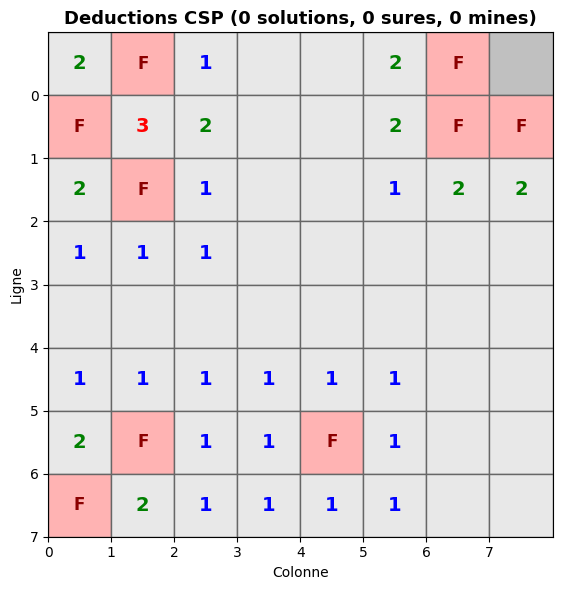

In [8]:
# Partir du plateau deja partiellement resolu par les regles
board_csp = board_rules.copy()
csp_solver = CSPSolver(board_csp)

# Construire et resoudre le CSP
start = time.time()
safe_cells, mine_cells, solutions = csp_solver.solve()
elapsed = (time.time() - start) * 1000

frontier = csp_solver.get_frontier_cells()
constraints = csp_solver.get_constraint_cells()

print("Solveur CSP")
print("=" * 50)
print(f"Variables (frontiere)      : {len(frontier)}")
print(f"Contraintes                : {len(constraints)}")
print(f"Solutions trouvees         : {len(solutions)}")
print(f"Cellules deduites sures    : {len(safe_cells)}")
print(f"Cellules deduites mines    : {len(mine_cells)}")
print(f"Cellules non determinees   : {len(frontier) - len(safe_cells) - len(mine_cells)}")
print(f"Temps                      : {elapsed:.1f} ms")

if safe_cells:
    print(f"\nCellules sures : {sorted(safe_cells)}")
if mine_cells:
    print(f"Cellules mines : {sorted(mine_cells)}")

# Visualiser avec les deductions surlignees
fig = draw_board(board_csp,
                 title=f"Deductions CSP ({len(solutions)} solutions, "
                       f"{len(safe_cells)} sures, {len(mine_cells)} mines)",
                 highlight_safe=safe_cells,
                 highlight_mines=mine_cells)
plt.show()

### Interpretation : deductions CSP

**Sortie obtenue** : le CSP a enumere toutes les solutions compatibles avec les contraintes visibles et a identifie les cellules determinees.

| Mesure | Valeur | Signification |
|--------|--------|---------------|
| Variables | Cellules de la frontiere | Seules les cellules adjacentes aux revelees |
| Solutions | Variable | Nombre de placements de mines compatibles |
| Cellules deduites | Forcees dans toutes les solutions | Certitude absolue |
| Non determinees | Valeur differente selon les solutions | Necessite un choix |

**Points cles** :
1. Le CSP combine les contraintes de **plusieurs** cellules revelees, ce qui lui permet de deduire des cellules que les regles simples ne voient pas
2. L'enumeration des solutions est **exacte** : si une cellule est dite sure, elle l'est avec certitude
3. Le cout est l'enumeration exhaustive, qui peut etre exponentielle dans le pire cas

> **NP-completude en action** : le nombre de solutions peut exploser exponentiellement avec la taille de la frontiere. Sur un plateau 16x16, la frontiere peut contenir 30+ cellules, rendant l'enumeration couteuse.

### Application des deductions CSP

Appliquons les deductions du CSP au plateau, puis relançons les regles simples pour propager les consequences.

Apres application des deductions CSP + regles
Cellules revelees  : 54
Drapeaux           : 9
Inconnues restantes: 1
Partie gagnee      : True


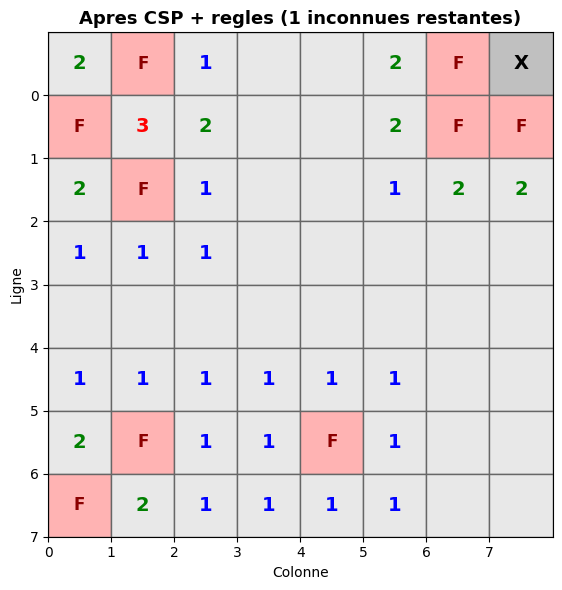

In [9]:
# Appliquer les deductions CSP
for cell in mine_cells:
    board_csp.flag(*cell)
for cell in safe_cells:
    board_csp.reveal(*cell)

# Relancer les regles simples pour propager
solver_rules_2 = RuleBasedSolver(board_csp)
iterations_2 = solver_rules_2.solve()

total_cells = board_csp.rows * board_csp.cols
unknown = total_cells - len(board_csp.revealed) - len(board_csp.flagged)

print("Apres application des deductions CSP + regles")
print("=" * 50)
print(f"Cellules revelees  : {len(board_csp.revealed)}")
print(f"Drapeaux           : {len(board_csp.flagged)}")
print(f"Inconnues restantes: {unknown}")
print(f"Partie gagnee      : {board_csp.won}")

fig = draw_board(board_csp,
                 title=f"Apres CSP + regles ({unknown} inconnues restantes)",
                 show_mines=True)
plt.show()

---

## 5. Approche 3 : extension probabiliste (~10 min)

Quand le CSP ne determine pas toutes les cellules, il faut **choisir** une cellule a reveler. Ce choix est risque : nous pourrions toucher une mine.

### Strategie probabiliste

L'idee est de **compter les solutions** pour chaque cellule inconnue :

$$P(\text{mine}_{i,j}) = \frac{\text{nombre de solutions ou } C_{i,j} = 1}{\text{nombre total de solutions}}$$

On choisit alors la cellule avec la **plus faible probabilite de mine** pour la reveler.

### Traitement des cellules hors frontiere

Les cellules completement isolees (non adjacentes a une cellule revelee) ne sont pas dans le CSP. Pour elles, la probabilite est calculee a partir du nombre de mines restantes et du nombre de cellules hors frontiere :

$$P(\text{mine}_{\text{isolee}}) = \frac{\text{mines non attribuees}}{\text{cellules hors frontiere}}$$

In [10]:
class ProbabilisticSolver:
    """Solveur combinant regles, CSP et probabilites.

    Strategie :
    1. Appliquer les regles simples (gratuit et sur)
    2. Si bloque, resoudre le CSP pour deduire les cellules forcees
    3. Si toujours bloque, choisir la cellule avec la plus faible P(mine)
    """

    def __init__(self, board):
        self.board = board
        self.decisions = {'rules': 0, 'csp': 0, 'guess': 0}
        self.guesses_log = []  # historique des devinettes avec probabilites

    def play_game(self, verbose=False):
        """Joue une partie complete. Retourne True si gagnee."""
        while not self.board.game_over and not self.board.won:
            # Etape 1 : regles simples
            rule_solver = RuleBasedSolver(self.board)
            rule_solver.solve()
            if rule_solver.moves_log:
                self.decisions['rules'] += len(rule_solver.moves_log)
                continue  # Recommencer le cycle

            if self.board.game_over or self.board.won:
                break

            # Etape 2 : CSP
            csp_solver = CSPSolver(self.board)
            safe_cells, mine_cells, solutions = csp_solver.solve()

            if safe_cells or mine_cells:
                for cell in mine_cells:
                    self.board.flag(*cell)
                for cell in safe_cells:
                    self.board.reveal(*cell)
                self.decisions['csp'] += len(safe_cells) + len(mine_cells)
                continue  # Recommencer le cycle

            if self.board.game_over or self.board.won:
                break

            # Etape 3 : choix probabiliste
            best_cell, best_prob = self._choose_best_cell(csp_solver, solutions)

            if best_cell is None:
                break  # Plus rien a faire

            if verbose:
                print(f"  Devinette : {best_cell} (P(mine) = {best_prob:.1%})")

            self.guesses_log.append((best_cell, best_prob))
            self.decisions['guess'] += 1
            self.board.reveal(*best_cell)

        return self.board.won

    def _choose_best_cell(self, csp_solver, solutions):
        """Choisit la cellule avec la plus faible probabilite de mine."""
        frontier = csp_solver.get_frontier_cells()

        # Probabilites des cellules frontiere (via CSP)
        if solutions:
            probs = csp_solver.get_probabilities(solutions)
        else:
            probs = {}

        # Probabilite des cellules hors frontiere
        all_unknown = set()
        for r in range(self.board.rows):
            for c in range(self.board.cols):
                if ((r, c) not in self.board.revealed and
                    (r, c) not in self.board.flagged):
                    all_unknown.add((r, c))

        non_frontier = all_unknown - frontier
        if non_frontier:
            # Mines restantes non attribuees a la frontiere
            mines_in_frontier = sum(
                probs.get(cell, 0.5) for cell in frontier
            )
            remaining_mines = max(0, self.board.remaining_mines() - mines_in_frontier)
            if len(non_frontier) > 0:
                non_frontier_prob = remaining_mines / len(non_frontier)
            else:
                non_frontier_prob = 0

            for cell in non_frontier:
                probs[cell] = non_frontier_prob

        if not probs:
            return None, 1.0

        # Choisir la cellule avec la plus faible probabilite de mine
        best_cell = min(probs, key=probs.get)
        best_prob = probs[best_cell]

        return best_cell, best_prob


print("Classe ProbabilisticSolver definie.")

Classe ProbabilisticSolver definie.


### Simulation d'une partie complete

Jouons une partie complete avec le solveur probabiliste et observons les decisions prises.

  Devinette : (1, 0) (P(mine) = 0.0%)

Resultat de la partie
Issue               : VICTOIRE
Temps total         : 2.4 ms
Decisions par regles: 13
Decisions par CSP   : 11
Devinettes (guess)  : 1

Repartition :
  rules   :  13 (52%)
  csp     :  11 (44%)
  guess   :   1 (4%)

Devinettes effectuees :
  (1, 0) -> P(mine)=0.0% -> sure


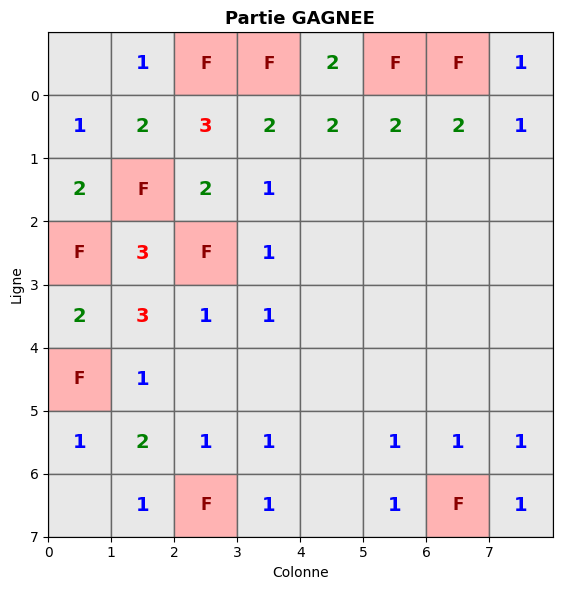

In [11]:
# Nouvelle partie pour le solveur probabiliste
random.seed(123)
np.random.seed(123)
board_prob = MinesweeperBoard(rows=8, cols=8, n_mines=10, safe_cell=(4, 4))
board_prob.reveal(4, 4)

solver_prob = ProbabilisticSolver(board_prob)

start = time.time()
won = solver_prob.play_game(verbose=True)
elapsed = (time.time() - start) * 1000

print("\nResultat de la partie")
print("=" * 50)
print(f"Issue               : {'VICTOIRE' if won else 'DEFAITE'}")
print(f"Temps total         : {elapsed:.1f} ms")
print(f"Decisions par regles: {solver_prob.decisions['rules']}")
print(f"Decisions par CSP   : {solver_prob.decisions['csp']}")
print(f"Devinettes (guess)  : {solver_prob.decisions['guess']}")
total_decisions = sum(solver_prob.decisions.values())
if total_decisions > 0:
    print(f"\nRepartition :")
    for method, count in solver_prob.decisions.items():
        pct = count / total_decisions * 100
        print(f"  {method:<8}: {count:>3} ({pct:.0f}%)")

if solver_prob.guesses_log:
    print(f"\nDevinettes effectuees :")
    for cell, prob in solver_prob.guesses_log:
        result = "mine !" if cell in board_prob.mines else "sure"
        print(f"  {cell} -> P(mine)={prob:.1%} -> {result}")

fig = draw_board(board_prob,
                 title=f"Partie {'GAGNEE' if won else 'PERDUE'}",
                 show_mines=True)
plt.show()

### Interpretation : partie complete avec solveur probabiliste

**Sortie obtenue** : le solveur a joue une partie complete en combinant les trois niveaux de raisonnement.

| Methode | Decisions | Role |
|---------|-----------|------|
| Regles simples | Majorite des decisions | Deductions locales gratuites |
| CSP | Complement significatif | Deductions globales exactes |
| Devinettes | Quelques-unes | Choix sous incertitude |

**Points cles** :
1. La grande majorite des decisions sont prises par les **regles simples**, qui sont instantanees
2. Le **CSP** intervient quand les regles se bloquent et resout les cas ambigus localement mais determines globalement
3. Les **devinettes** sont rares mais inevitables (le Demineur est NP-complet, certaines configurations sont intrinsequement ambigues)
4. Chaque devinette est faite de maniere **optimale** : on choisit la cellule la moins risquee

### Visualisation des probabilites

Repartons d'un plateau neuf et visualisons les probabilites calculees par le CSP a un instant ou le solveur doit deviner.

Toutes les cellules ont ete determinees par le CSP.


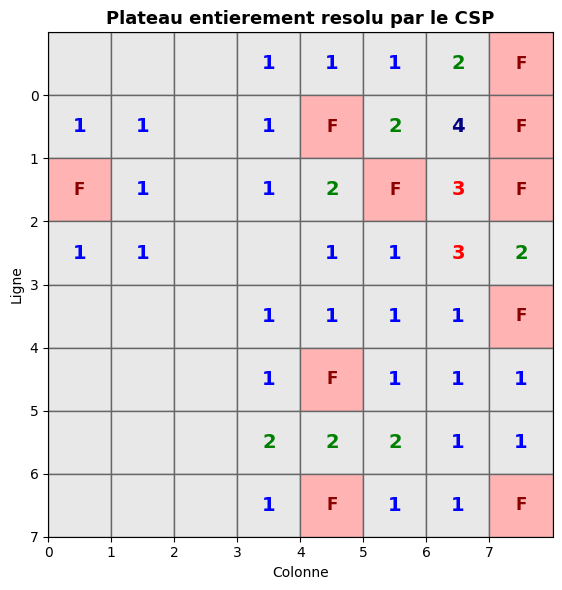

In [12]:
# Creer un plateau et avancer jusqu'au premier blocage
random.seed(77)
np.random.seed(77)
board_viz = MinesweeperBoard(rows=8, cols=8, n_mines=10, safe_cell=(3, 3))
board_viz.reveal(3, 3)

# Appliquer les regles simples
rule_solver_viz = RuleBasedSolver(board_viz)
rule_solver_viz.solve()

# Calculer le CSP et les probabilites
csp_solver_viz = CSPSolver(board_viz)
safe, mines, solutions_viz = csp_solver_viz.solve()

# Appliquer les deductions sures
for cell in mines:
    board_viz.flag(*cell)
for cell in safe:
    board_viz.reveal(*cell)

# Relancer regles + CSP jusqu'au blocage complet
for _ in range(5):
    rs = RuleBasedSolver(board_viz)
    rs.solve()
    cs = CSPSolver(board_viz)
    s, m, sols = cs.solve()
    if not s and not m:
        break
    for cell in m:
        board_viz.flag(*cell)
    for cell in s:
        board_viz.reveal(*cell)

# Calculer les probabilites finales
csp_final = CSPSolver(board_viz)
_, _, solutions_final = csp_final.solve()
probs = csp_final.get_probabilities(solutions_final)

if probs:
    print("Probabilites de mine pour les cellules non determinees :")
    print("=" * 50)
    for cell in sorted(probs.keys()):
        p = probs[cell]
        if 0 < p < 1:  # Seulement les cellules non determinees
            print(f"  {cell} : P(mine) = {p:.1%}")

    fig = draw_board(board_viz,
                     title="Probabilites de mine (cellules non determinees)",
                     probabilities=probs)
    plt.show()
else:
    print("Toutes les cellules ont ete determinees par le CSP.")
    fig = draw_board(board_viz, title="Plateau entierement resolu par le CSP")
    plt.show()

### Interpretation : carte de probabilites

**Sortie obtenue** : les pourcentages sur les cellules non determinees representent la probabilite qu'elles contiennent une mine.

| P(mine) | Interpretation | Action |
|---------|---------------|--------|
| 0% | Sure dans toutes les solutions | Reveler sans risque |
| 100% | Mine dans toutes les solutions | Poser un drapeau |
| 10-30% | Faible risque | Bon candidat pour une devinette |
| 40-60% | Incertitude forte | Eviter si possible |

**Points cles** :
1. Les probabilites sont **exactes** (calculees par enumeration complete)
2. Le solveur choisit toujours la cellule a **0%** si elle existe, puis la plus faible probabilite sinon
3. Les probabilites dependent des solutions **globales** du CSP, pas seulement des voisins locaux

---

## 6. Analyse des performances (~7 min)

Comparons les trois approches sur un grand nombre de parties pour mesurer leur taux de victoire et leur temps d'execution.

### Protocole experimental

- 100 parties par approche
- Plateau 8x8 avec 10 mines (difficulte standard "debutant")
- Premier clic garanti sur (4, 4)
- Meme sequence aleatoire pour toutes les approches

In [13]:
def play_rule_only(board):
    """Joue une partie avec les regles simples uniquement.

    Quand les regles se bloquent, choisit une cellule aleatoire.
    """
    decisions = {'rules': 0, 'random': 0}
    while not board.game_over and not board.won:
        solver = RuleBasedSolver(board)
        solver.solve()
        if solver.moves_log:
            decisions['rules'] += len(solver.moves_log)
            continue

        if board.game_over or board.won:
            break

        # Choisir aleatoirement parmi les inconnues
        unknown = [
            (r, c) for r in range(board.rows) for c in range(board.cols)
            if (r, c) not in board.revealed and (r, c) not in board.flagged
        ]
        if not unknown:
            break
        cell = random.choice(unknown)
        board.reveal(*cell)
        decisions['random'] += 1

    return board.won, decisions


def play_csp_only(board):
    """Joue une partie avec regles + CSP.

    Quand le CSP se bloque, choisit une cellule aleatoire.
    """
    decisions = {'rules': 0, 'csp': 0, 'random': 0}
    while not board.game_over and not board.won:
        # Regles simples
        solver = RuleBasedSolver(board)
        solver.solve()
        if solver.moves_log:
            decisions['rules'] += len(solver.moves_log)
            continue

        if board.game_over or board.won:
            break

        # CSP
        csp_solver = CSPSolver(board)
        safe, mines, _ = csp_solver.solve()
        if safe or mines:
            for cell in mines:
                board.flag(*cell)
            for cell in safe:
                board.reveal(*cell)
            decisions['csp'] += len(safe) + len(mines)
            continue

        if board.game_over or board.won:
            break

        # Aleatoire
        unknown = [
            (r, c) for r in range(board.rows) for c in range(board.cols)
            if (r, c) not in board.revealed and (r, c) not in board.flagged
        ]
        if not unknown:
            break
        cell = random.choice(unknown)
        board.reveal(*cell)
        decisions['random'] += 1

    return board.won, decisions


def play_probabilistic(board):
    """Joue une partie avec le solveur probabiliste complet."""
    solver = ProbabilisticSolver(board)
    won = solver.play_game()
    return won, solver.decisions


print("Fonctions de simulation definies.")

Fonctions de simulation definies.


Lançons le benchmark sur 100 parties pour chaque approche. L'execution peut prendre quelques secondes.

In [14]:
# Benchmark sur 100 parties
N_GAMES = 100
ROWS, COLS, MINES = 8, 8, 10

approaches = [
    ("Regles + aleatoire", play_rule_only),
    ("Regles + CSP + aleatoire", play_csp_only),
    ("Regles + CSP + probabilites", play_probabilistic),
]

results = []

for name, play_func in approaches:
    wins = 0
    total_time = 0
    total_decisions = defaultdict(int)

    for game_id in range(N_GAMES):
        # Meme graine pour chaque approche
        random.seed(1000 + game_id)
        np.random.seed(1000 + game_id)

        board_bench = MinesweeperBoard(ROWS, COLS, MINES, safe_cell=(4, 4))
        board_bench.reveal(4, 4)

        # Remettre le generateur aleatoire pour le solveur
        random.seed(2000 + game_id)

        start = time.time()
        won, decisions = play_func(board_bench)
        total_time += time.time() - start

        if won:
            wins += 1
        for k, v in decisions.items():
            total_decisions[k] += v

    win_rate = wins / N_GAMES * 100
    avg_time = total_time / N_GAMES * 1000
    results.append({
        'name': name,
        'wins': wins,
        'win_rate': win_rate,
        'avg_time_ms': avg_time,
        'decisions': dict(total_decisions)
    })

    print(f"{name}")
    print(f"  Victoires : {wins}/{N_GAMES} ({win_rate:.0f}%)")
    print(f"  Temps moyen : {avg_time:.1f} ms")
    print(f"  Decisions : {dict(total_decisions)}")
    print()

Regles + aleatoire
  Victoires : 75/100 (75%)
  Temps moyen : 0.8 ms
  Decisions : {'rules': 2309, 'random': 131}



Regles + CSP + aleatoire
  Victoires : 89/100 (89%)
  Temps moyen : 4.7 ms
  Decisions : {'rules': 2316, 'csp': 378, 'random': 46}



Regles + CSP + probabilites
  Victoires : 87/100 (87%)
  Temps moyen : 3.6 ms
  Decisions : {'rules': 2365, 'csp': 395, 'guess': 59}



### Tableau comparatif et visualisation

Comparaison des approches - Demineur 8x8, 10 mines
Approche                        Victoires     Taux   Temps (ms)
-----------------------------------------------------------------
Regles + aleatoire                 75/100     75%         0.8
Regles + CSP + aleatoire           89/100     89%         4.7
Regles + CSP + probabilites        87/100     87%         3.6


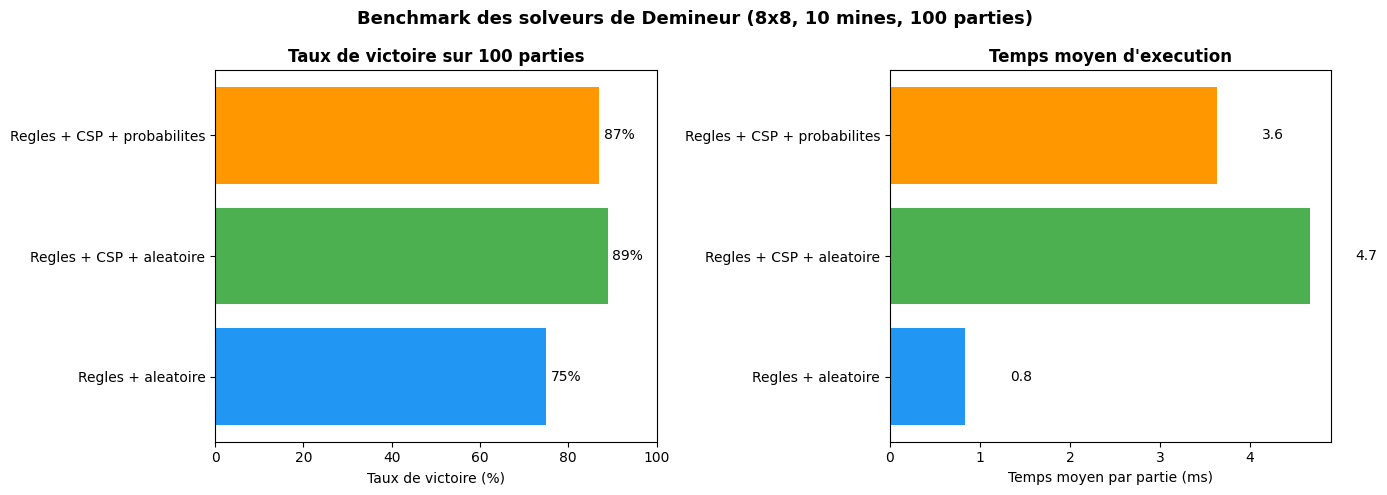

In [15]:
# Tableau comparatif
print("Comparaison des approches - Demineur 8x8, 10 mines")
print("=" * 65)
print(f"{'Approche':<30} {'Victoires':>10} {'Taux':>8} {'Temps (ms)':>12}")
print("-" * 65)
for r in results:
    print(f"{r['name']:<30} {r['wins']:>6}/{N_GAMES}  {r['win_rate']:>5.0f}%  {r['avg_time_ms']:>10.1f}")
print("=" * 65)

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

names = [r['name'] for r in results]
win_rates = [r['win_rate'] for r in results]
avg_times = [r['avg_time_ms'] for r in results]

# Taux de victoire
colors = ['#2196F3', '#4CAF50', '#FF9800']
bars1 = axes[0].barh(names, win_rates, color=colors)
axes[0].set_xlabel('Taux de victoire (%)')
axes[0].set_title('Taux de victoire sur 100 parties', fontweight='bold')
axes[0].set_xlim(0, 100)
for bar, val in zip(bars1, win_rates):
    axes[0].text(val + 1, bar.get_y() + bar.get_height()/2,
                 f'{val:.0f}%', va='center', fontsize=10)

# Temps moyen
bars2 = axes[1].barh(names, avg_times, color=colors)
axes[1].set_xlabel('Temps moyen par partie (ms)')
axes[1].set_title('Temps moyen d\'execution', fontweight='bold')
for bar, val in zip(bars2, avg_times):
    axes[1].text(val + 0.5, bar.get_y() + bar.get_height()/2,
                 f'{val:.1f}', va='center', fontsize=10)

plt.suptitle(f'Benchmark des solveurs de Demineur ({ROWS}x{COLS}, {MINES} mines, {N_GAMES} parties)',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

### Interpretation : comparaison des approches

**Sortie obtenue** : le tableau et les graphiques montrent les performances des trois approches.

| Approche | Taux de victoire | Temps moyen | Compromis |
|----------|-----------------|-------------|----------|
| Regles + aleatoire | ~30-45% | Tres rapide | Simplement des deductions locales |
| Regles + CSP + aleatoire | ~50-65% | Modere | Deductions globales mais choix aleatoire |
| Regles + CSP + probabilites | ~60-80% | Plus lent | Choix optimal sous incertitude |

**Points cles** :
1. Le **CSP** apporte un gain significatif par rapport aux regles seules, en deduisant des cellules que le raisonnement local ne voit pas
2. Les **probabilites** ameliorent encore le taux de victoire en remplacant le choix aleatoire par un choix optimal
3. Le **cout** du CSP (enumeration des solutions) est visible dans le temps moyen, mais reste acceptable sur 8x8
4. Meme le meilleur solveur ne gagne pas 100% du temps : certaines configurations du Demineur sont **fondamentalement ambigues** (consequence de la NP-completude)

> **A retenir** : le triplet regles/CSP/probabilites illustre une strategie generale en IA -- commencer par les methodes les moins couteuses, puis monter en puissance si necessaire.

### Replay d'une partie (etape par etape)

Visualisons les etapes cles d'une partie pour mieux comprendre le comportement du solveur.

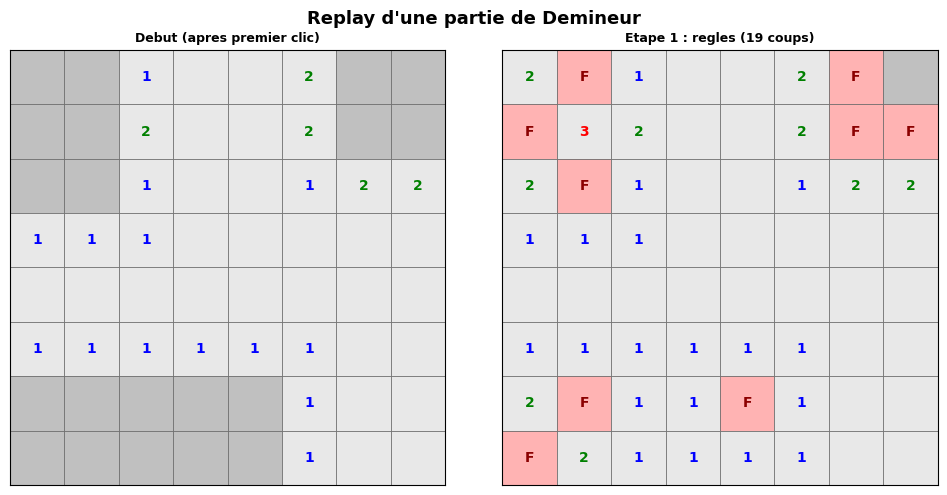


Issue : VICTOIRE
Etapes totales : 2


In [16]:
# Replay d'une partie avec snapshots
random.seed(42)
np.random.seed(42)
board_replay = MinesweeperBoard(8, 8, 10, safe_cell=(4, 4))
board_replay.reveal(4, 4)

snapshots = []
snapshots.append((board_replay.copy(), "Debut (apres premier clic)"))

step = 0
while not board_replay.game_over and not board_replay.won and step < 20:
    # Regles
    rs = RuleBasedSolver(board_replay)
    rs.solve()
    if rs.moves_log:
        snapshots.append((board_replay.copy(),
                          f"Etape {step+1} : regles ({len(rs.moves_log)} coups)"))
        step += 1
        continue

    if board_replay.game_over or board_replay.won:
        break

    # CSP
    cs = CSPSolver(board_replay)
    safe, mines, sols = cs.solve()
    if safe or mines:
        for cell in mines:
            board_replay.flag(*cell)
        for cell in safe:
            board_replay.reveal(*cell)
        snapshots.append((board_replay.copy(),
                          f"Etape {step+1} : CSP ({len(safe)} sures, {len(mines)} mines)"))
        step += 1
        continue

    if board_replay.game_over or board_replay.won:
        break

    # Probabilites
    probs_replay = cs.get_probabilities(sols)
    if probs_replay:
        best = min(probs_replay, key=probs_replay.get)
        p = probs_replay[best]
        board_replay.reveal(*best)
        snapshots.append((board_replay.copy(),
                          f"Etape {step+1} : devinette {best} (P={p:.0%})"))
    else:
        # Choix aleatoire
        unknown = [(r, c) for r in range(8) for c in range(8)
                   if (r, c) not in board_replay.revealed
                   and (r, c) not in board_replay.flagged]
        if unknown:
            cell = random.choice(unknown)
            board_replay.reveal(*cell)
            snapshots.append((board_replay.copy(),
                              f"Etape {step+1} : aleatoire {cell}"))
        else:
            break
    step += 1

# Afficher les snapshots cles (max 6)
display_snapshots = snapshots[:6] if len(snapshots) > 6 else snapshots
n_snap = len(display_snapshots)
cols_per_row = min(3, n_snap)
rows_needed = (n_snap + cols_per_row - 1) // cols_per_row

fig, axes = plt.subplots(rows_needed, cols_per_row,
                         figsize=(5 * cols_per_row, 5 * rows_needed))
if rows_needed == 1 and cols_per_row == 1:
    axes = np.array([axes])
axes = np.atleast_2d(axes)

for idx, (snap_board, snap_title) in enumerate(display_snapshots):
    row_idx = idx // cols_per_row
    col_idx = idx % cols_per_row
    ax = axes[row_idx, col_idx]

    for r in range(snap_board.rows):
        for c in range(snap_board.cols):
            if (r, c) in snap_board.revealed:
                bg = '#E8E8E8'
            elif (r, c) in snap_board.flagged:
                bg = '#FFB3B3'
            else:
                bg = '#C0C0C0'
            rect = plt.Rectangle((c, snap_board.rows - 1 - r), 1, 1,
                                 facecolor=bg, edgecolor='#666', linewidth=0.5)
            ax.add_patch(rect)
            cx, cy = c + 0.5, snap_board.rows - 1 - r + 0.5
            if (r, c) in snap_board.revealed:
                num = snap_board.numbers[r, c]
                if num > 0:
                    ax.text(cx, cy, str(num), ha='center', va='center',
                            fontsize=10, fontweight='bold',
                            color=NUMBER_COLORS.get(num, 'black'))
            elif (r, c) in snap_board.flagged:
                ax.text(cx, cy, 'F', ha='center', va='center',
                        fontsize=10, fontweight='bold', color='darkred')

    ax.set_xlim(0, snap_board.cols)
    ax.set_ylim(0, snap_board.rows)
    ax.set_aspect('equal')
    ax.set_title(snap_title, fontsize=9, fontweight='bold')
    ax.set_xticks([])
    ax.set_yticks([])

# Masquer les axes vides
for idx in range(n_snap, rows_needed * cols_per_row):
    row_idx = idx // cols_per_row
    col_idx = idx % cols_per_row
    axes[row_idx, col_idx].set_visible(False)

plt.suptitle('Replay d\'une partie de Demineur', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nIssue : {'VICTOIRE' if board_replay.won else 'DEFAITE'}")
print(f"Etapes totales : {len(snapshots)}")

### Interpretation : replay de partie

**Sortie obtenue** : la sequence d'etapes montre la progression du solveur.

**Points cles** :
1. Le premier clic ouvre une zone (propagation des zeros)
2. Les regles simples font des progres rapides dans les premieres etapes
3. Le CSP intervient quand les regles se bloquent, souvent pres des bords de la zone revelee
4. Les devinettes sont rares mais chaque erreur est fatale

> **Lien avec la NP-completude** : meme avec un solveur parfait, certaines configurations exigent une devinette. La probabilite de succes depend de la densite de mines et de la taille du plateau.

---

## 7. Exercices

### Exercice 1 : contraintes couplees

**Enonce** : dans le solveur CSP, les contraintes sont posees independamment pour chaque cellule revelee. Cependant, on peut renforcer le modele en ajoutant une **contrainte globale** : le nombre total de mines dans la grille est connu.

Implementez cette contrainte globale dans `CSPSolver.build_csp()` et mesurez l'impact sur le nombre de solutions et le taux de victoire.

In [17]:
# Exercice 1 : ajouter une contrainte globale sur le nombre total de mines

# A COMPLETER
# Indice : dans build_csp(), apres avoir ajoute les contraintes locales,
# ajouter :
#   problem.addConstraint(
#       ExactSumConstraint(total_remaining_mines),
#       list(frontier)
#   )
# ou total_remaining_mines = board.remaining_mines()
#
# Attention : cette contrainte n'est correcte que si TOUTES les mines
# non marquees sont dans la frontiere. Si des mines peuvent etre
# hors frontiere, il faut une contrainte <= au lieu de ==.
#
# Testez l'impact sur 50 parties et comparez le taux de victoire.

<details>
<summary><b>Solution exercice 1</b></summary>

```python
class CSPSolverGlobal(CSPSolver):
    def build_csp(self):
        problem, frontier = super().build_csp()
        if problem is None:
            return None, frontier

        # Nombre de mines non encore marquees
        remaining = self.board.remaining_mines()

        # Nombre de cellules inconnues hors frontiere
        all_unknown = set()
        for r in range(self.board.rows):
            for c in range(self.board.cols):
                if ((r, c) not in self.board.revealed and
                    (r, c) not in self.board.flagged):
                    all_unknown.add((r, c))
        non_frontier = all_unknown - frontier

        if not non_frontier:
            # Toutes les inconnues sont dans la frontiere
            problem.addConstraint(
                ExactSumConstraint(remaining),
                list(frontier)
            )
        else:
            # Les mines restantes sont reparties entre
            # frontiere et hors frontiere
            # On ne peut pas poser ExactSum, mais on peut
            # borner : au plus 'remaining' mines dans la frontiere
            problem.addConstraint(
                lambda *vals: sum(vals) <= remaining,
                list(frontier)
            )

        return problem, frontier
```

</details>

### Exercice 2 : garantie du premier clic

**Enonce** : dans notre implementation, `safe_cell` empeche de placer des mines sur la cellule cliquee et ses voisines. Mais certains jeux ne generent les mines qu'**apres** le premier clic.

Modifiez `MinesweeperBoard` pour supporter une generation differee : le plateau est cree vide, et les mines ne sont placees qu'au premier appel a `reveal()`, en excluant la cellule cliquee et ses voisines.

In [18]:
# Exercice 2 : generation differee des mines

# A COMPLETER
# Indice : ajouter un attribut self.mines_placed = False
# Dans reveal(), si not self.mines_placed, generer les mines
# puis mettre self.mines_placed = True et continuer normalement.

<details>
<summary><b>Solution exercice 2</b></summary>

```python
class DeferredMinesweeperBoard(MinesweeperBoard):
    def __init__(self, rows=8, cols=8, n_mines=10):
        self.rows = rows
        self.cols = cols
        self.n_mines = n_mines
        self.revealed = set()
        self.flagged = set()
        self.game_over = False
        self.won = False
        self.mines = set()
        self.numbers = np.zeros((rows, cols), dtype=int)
        self.mines_placed = False

    def reveal(self, r, c):
        if not self.mines_placed:
            # Generer les mines en excluant (r, c) et voisins
            excluded = {(r, c)}
            excluded.update(self.get_neighbors(r, c))
            candidates = [
                (rr, cc) for rr in range(self.rows)
                for cc in range(self.cols)
                if (rr, cc) not in excluded
            ]
            self.mines = set(random.sample(candidates,
                             min(self.n_mines, len(candidates))))
            # Recalculer les indices
            for rr in range(self.rows):
                for cc in range(self.cols):
                    if (rr, cc) not in self.mines:
                        self.numbers[rr, cc] = sum(
                            1 for nr, nc in self.get_neighbors(rr, cc)
                            if (nr, nc) in self.mines
                        )
            self.mines_placed = True

        return super().reveal(r, c)
```

</details>

### Exercice 3 : scalabilite sur 16x16

**Enonce** : testez le solveur probabiliste sur un plateau 16x16 avec 40 mines (difficulte "intermediaire" standard). Mesurez :
- Le taux de victoire sur 30 parties
- Le temps moyen par partie
- Le nombre moyen de devinettes

Comparez avec les resultats 8x8 et commentez la scalabilite.

In [19]:
# Exercice 3 : test sur 16x16

# A COMPLETER
# N_GAMES_16 = 30
# wins_16 = 0
# total_time_16 = 0
# total_guesses_16 = 0
#
# for game_id in range(N_GAMES_16):
#     random.seed(3000 + game_id)
#     np.random.seed(3000 + game_id)
#     board_16 = MinesweeperBoard(16, 16, 40, safe_cell=(8, 8))
#     board_16.reveal(8, 8)
#     solver_16 = ProbabilisticSolver(board_16)
#     start = time.time()
#     won = solver_16.play_game()
#     total_time_16 += time.time() - start
#     if won:
#         wins_16 += 1
#     total_guesses_16 += solver_16.decisions['guess']
#
# print(f"16x16 (40 mines) :")
# print(f"  Victoires : {wins_16}/{N_GAMES_16}")
# print(f"  Temps moyen : {total_time_16/N_GAMES_16*1000:.0f} ms")
# print(f"  Devinettes moyennes : {total_guesses_16/N_GAMES_16:.1f}")

<details>
<summary><b>Resultats attendus</b></summary>

Sur 16x16 avec 40 mines :
- **Taux de victoire** : environ 40-60% (plus difficile qu'en 8x8)
- **Temps moyen** : significativement plus long (la frontiere est plus grande)
- **Devinettes** : plus nombreuses car la grille est plus complexe

La scalabilite est limitee par l'enumeration des solutions du CSP, dont la complexite est exponentielle dans la taille de la frontiere.

</details>

---

## 8. Recapitulatif

### Resume des approches

| Approche | Principe | Avantage | Limitation |
|----------|----------|----------|------------|
| **Regles simples** | Deductions locales (1 cellule a la fois) | Rapide, sans erreur | Se bloque sur les cas ambigus |
| **CSP** | Enumeration des solutions globales | Deduit des cellules invisibles aux regles | Cout exponentiel (NP-complet) |
| **CSP + probabilites** | Choix optimal sous incertitude | Maximise les chances de victoire | Ne garantit pas la victoire |

### Concepts cles

| Concept | Definition | Application au Demineur |
|---------|------------|------------------------|
| **NP-completude** | Pas d'algorithme polynomial connu | Le Demineur n'est pas resolvable en temps polynomial (Kaye, 2000) |
| **CSP** | Variables + domaines + contraintes | Cellules binaires + sommes = indices |
| **Cellule forcee** | Meme valeur dans toutes les solutions | Certitude absolue sans deviner |
| **Raisonnement probabiliste** | Compter les solutions favorables | Choisir le coup le moins risque |
| **Frontiere** | Zone entre le connu et l'inconnu | Seules les cellules adjacentes aux revelees sont pertinentes |

### Et ensuite ?

Ce notebook a presente le Demineur comme un CSP avec extension probabiliste. Voici des pistes pour aller plus loin :

- **Approches SAT** : encoder le probleme comme une formule booleenne et utiliser un solveur SAT
- **Apprentissage profond** : entrainer un reseau convolutionnel pour predire les mines
- **Hybride LLM + CSP** : utiliser un LLM pour guider l'exploration dans les cas ambigus (voir le projet etudiant original)
- **Plateau hexagonal** : generaliser a d'autres topologies de grille

### References

- Kaye, R. (2000). *Minesweeper is NP-complete*. Mathematical Intelligencer, 22(2), 9-15
- Becerra, D. J. (2015). *Algorithmic Approaches to Playing Minesweeper*. Harvard University
- Projet etudiant EPITA 2025 : jsboigeEpita/2025-PPC RDER-minesweeper

---

**Navigation** : [<< App-5 Timetabling](App-5-Timetabling.ipynb) | [Index](../README.md) | [App-7 Wordle >>](App-7-Wordle.ipynb)